<a href="https://colab.research.google.com/github/joangog/object-detection/blob/main/coco2017_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model evaluation (inference) on COCO 2017 dataset

The following models will be evaluated:

| Model | Backbone | Image Size | Parameters | GFLOPs
| --- | --- | --- | --- | --- |
| SSDlite320 | MobileNetV3-Large | 320x320 | 3.4M | 1.2 |
| SSD300 | VGG16 | 300x300 | 35.6M | 69.8 |
| Faster R-CNN |  MobileNetV3-Large FPN | 800x800 | 19.4M | 9.1 |
| Faster R-CNN |  ResNet-50 FPN | 800x800 | 41.8M | 269.1 |
| Mask R-CNN |  ResNet-50 FPN | 800x800 | 44.4M | 269.1 |
| YOLOv5s |  Custom | 640x640 | 7.3M | 17 |
| YOLOv5m |  Custom | 640x640 | 21.4M | 51.3 |
| YOLOv5l |  Custom |640x640 | 47M | 115.5 |
| YOLOv3-tiny |  Darknet53 | 640x640 | 8.8M | 13.3 |
| YOLOv3 |  Darknet53 | 640x640 | 61.9M | 156.3 |
| YOLOv3-spp |  Darknet53 | 640x640 | 63M | 157.1 |

<br>

**Note: GPU Runtime needed**

*Example experiment: Tesla K80, 460.32.03, 11441 MiB, batch_size=8, workers=2*




In [ ]:
# Show system specs
!nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv

name, driver_version, memory.total [MiB]
Tesla K80, 460.32.03, 11441 MiB


### Inference Parameters

In [1]:
# Parameters

num_workers = 2  #  Data loader workers
batch_size = 8  # Data loader batch size

th = 0.5  # Threshold for confidence score of predicted bboxes to show

### Get requirements
*Note: Restart runtime after installation*

In [3]:
%%shell

# Install Yolov5
cd /content
git clone https://github.com/ultralytics/yolov5
cd yolov5
pip install --quiet -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 9249, done.
remote: Total 9249 (delta 0), reused 0 (delta 0), pack-reused 9249
Receiving objects: 100% (9249/9249), 9.82 MiB | 27.10 MiB/s, done.
Resolving deltas: 100% (6417/6417), done.
     |████████████████████████████████| 636 kB 5.3 MB/s 


In [4]:
%%shell

# Install Yolov3
cd /content
git clone https://github.com/ultralytics/yolov3
cd yolov3
pip install --quiet -r requirements.txt

Cloning into 'yolov3'...
remote: Enumerating objects: 9862, done.
remote: Total 9862 (delta 0), reused 0 (delta 0), pack-reused 9862
Receiving objects: 100% (9862/9862), 9.19 MiB | 22.57 MiB/s, done.
Resolving deltas: 100% (6667/6667), done.


In [5]:
%%shell

# Install flops-counter
pip install ptflops

  Created wheel for ptflops: filename=ptflops-0.6.6-py3-none-any.whl size=8903 sha256=fe51ac885572b61970aecb59028974333c54275fd24885514c4b03ce777d6e58
  Stored in directory: /root/.cache/pip/wheels/eb/7c/e5/2332373fcac1b39ba9eb95698ac370da3e14eaba5516e22721
Successfully built ptflops


In [6]:
%%shell

# Clone asset files
cd /content
git clone https://github.com/joangog/object-detection-assets
cd object-detection-assets
mv -n scripts ../
rm -rf /content/object-detection-assets/

Cloning into 'object-detection-assets'...
remote: Enumerating objects: 87, done.
remote: Counting objects: 100% (87/87), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 87 (delta 26), reused 73 (delta 15), pack-reused 0
Unpacking objects: 100% (87/87), done.


### Import packages

In [7]:
from google.colab import files
from google.colab import drive
import gdown

import os, sys
import math
import time
import copy

import numpy as np
import pandas as pd
import json
import PIL

import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.models.detection as M
import torchvision.transforms.functional as F
import torchvision.utils as U
from torchvision.datasets import CocoDetection

from ptflops import get_model_complexity_info

import scripts.utils as SU
import scripts.transforms as ST
import scripts.engine as SE
import scripts.coco_utils as SCU
from scripts.coco_eval import CocoEvaluator

### Connect to GDrive for storage access

In [ ]:
drive.mount('/content/drive')

### Download COCO 2017 validation dataset

In [8]:
%%shell

cd /content
mkdir -p dataset

In [9]:
%%shell

cd /content/dataset

# Download images
wget -nc 'http://images.cocodataset.org/zips/val2017.zip'
unzip -q -n 'val2017.zip'

cd /content/dataset

# Download annotations
wget -nc 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'
unzip -q -n 'annotations_trainval2017.zip'
cp '/content/dataset/annotations/instances_val2017.json' '/content/dataset/val2017'

--2021-09-27 12:55:39--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.101.236
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.101.236|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  82.0MB/s    in 10s     

2021-09-27 12:55:50 (76.3 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

--2021-09-27 12:55:56--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.24.196
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.24.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  83.2MB/s    in 2.9s    

2021

### Load COCO 2017 validation dataset

In [10]:
img_dir = '/content/dataset/val2017'
ann_file = 'instances_val2017.json'  # annotations
ann_path = os.path.join(img_dir,ann_file)

# Define data transforms
transforms = ST.Compose([ST.ToTensor()])

# Create dataset
dataset = CocoDetection(img_dir, ann_path, transforms = transforms)

# Create data loader
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=SU.collate_fn)

loading annotations into memory...
Done (t=0.79s)
creating index...
index created!


### (Optional) Get dataset resolution information

In [ ]:
img_ids = dataset.coco.getImgIds()
img_x_arr = []
img_y_arr = []

for img_id in img_ids:
  img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
  img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
  img_shape = img_tensor.shape
  img_x_arr.append(img_shape[1])
  img_y_arr.append(img_shape[2])

img_x_mean = np.mean(img_x_arr)
img_y_mean = np.mean(img_y_arr)

img_x_max = np.max(img_x_arr)
img_y_max = np.max(img_y_arr)

print(f'Mean resolution: {img_x_mean,img_y_mean}')
print(f'Maximum resolution: {img_x_max,img_y_max}')


Mean resolution: (483.543, 573.7548)
Maximum resolution: (640, 640)


### Load pre-trained model

In [11]:
%cd /content

# Delete utils package to reload it (if loaded), because YOLOv3 and YOLOv5 have
# the same name for it and it causes error
try:
  sys.modules.pop('utils')
except:
  pass

# @markdown Model Selection { display-mode: 'form', run: 'auto' }
model_name = 'YOLOv3-tiny' # @param ['SSD300 VGG16', 'SSDlite320 MobileNetV3-Large', 'Faster R-CNN ResNet-50 FPN', 'Faster R-CNN MobileNetV3-Large FPN', 'Mask R-CNN ResNet-50 FPN', 'YOLOv5s', 'YOLOv5m', 'YOLOv5l', 'YOLOv3', 'YOLOv3-tiny', 'YOLOv3-spp']

# @markdown *Note: If you get the error "Cache may be out of date, try 'force_reload=True'" then restart runtime.*

if model_name == 'SSD300 VGG16':
  model_id = 'ssd300_vgg16'
  model = M.ssd300_vgg16(pretrained=True, progress=True)
  model_img_size = (3,300,300)
elif model_name == 'SSDlite320 MobileNetV3-Large':
  model_id = 'ssdlite320_mobilenet_v3_large'
  model = M.ssdlite320_mobilenet_v3_large(pretrained=True, progress=True)
  model_img_size = (3,320,320)
elif model_name == 'Faster R-CNN ResNet-50 FPN':
  model_id = 'fasterrcnn_resnet50_fpn'
  model = M.fasterrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) # COCO's 640x640 in upscaled to the model's minimum 800x800
elif model_name == 'Faster R-CNN MobileNetV3-Large FPN':
  model_id = 'fasterrcnn_mobilenet_v3_large_fpn'
  model = M.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800) 
elif model_name == 'Mask R-CNN ResNet-50 FPN':
  model_id = 'maskrcnn_resnet50_fpn'
  model = M.maskrcnn_resnet50_fpn(pretrained=True, progress=True)
  model_img_size = (3,800,800)
elif model_name == 'YOLOv5s':
  model_id = 'yolov5s'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5s', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5m':
  model_id = 'yolov5m'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5m', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv5l':
  model_id = 'yolov5l'
  model = torch.hub.load('ultralytics/yolov5', 'yolov5l', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3':
  model_id = 'yolov3'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-tiny':
  model_id = 'yolov3_tiny'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_tiny', force_reload=True)
  model_img_size = (3,640,640)
elif model_name == 'YOLOv3-spp':
  model_id = 'yolov3_spp'
  model = torch.hub.load('ultralytics/yolov3', 'yolov3_spp', force_reload=True)
  model_img_size = (3,640,640)

print('-------------------------------------------------------------------------------------------------------\n')

print(f'Loaded model: {model_name}')
model_params = round(sum([param.numel() for param in model.parameters()]) / 1000000, 1)
print(f'\t- Parameters: {model_params}M')
model_macs, _ = get_model_complexity_info(model, model_img_size, as_strings=False, 
                                          print_per_layer_stat=False, verbose=False)
model_gflops = round(2 * int(model_macs) / 1000000000, 1)
print(f'\t- GFLOPs: {model_gflops}')

/content


Downloading: "https://github.com/ultralytics/yolov3/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv3, attempting auto-update...

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov3_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/16.9M [00:00<?, ?B/s]

Fusing layers... 


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Model Summary: 48 layers, 8849182 parameters, 0 gradients
Adding AutoShape... 
YOLOv3 🚀 2021-9-27 torch 1.9.0+cu102 CPU



-------------------------------------------------------------------------------------------------------

Loaded model: YOLOv3-tiny
	- Parameters: 8.8M
	- GFLOPs: 13.3


### (Optional) Test model with image sample
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*


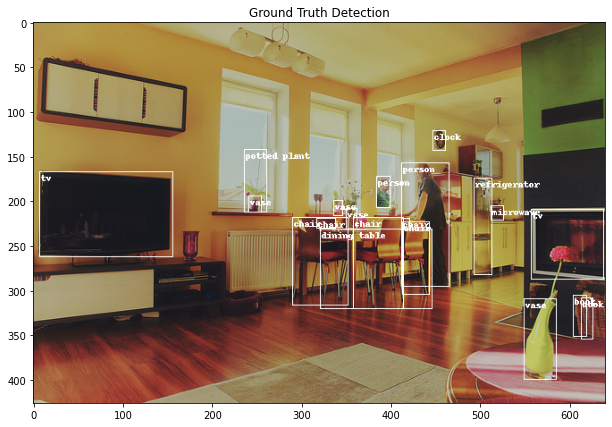

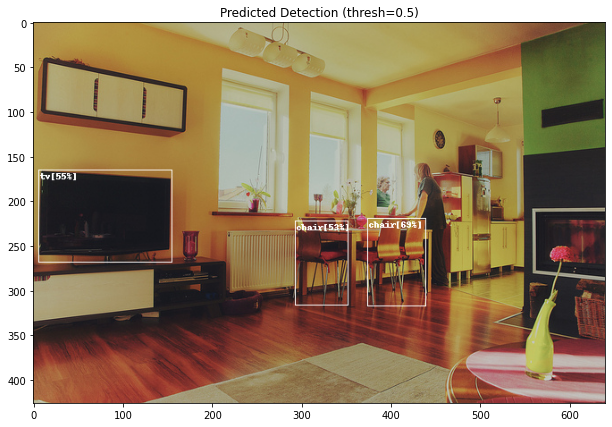

In [19]:
%matplotlib inline

# Parameters
img_id = 139

# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Get image sample
img = PIL.Image.open(os.path.join(img_dir,dataset.coco.loadImgs([img_id])[0]['file_name']))
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Get label names
label_ids = dataset.coco.getCatIds()
label_info = dataset.coco.loadCats(label_ids)
label_names = [label['name'] for label in label_info]
labels = dict(zip(label_ids,label_names))  # Label dictionary with id-name as key-value
labels_inv = dict(zip(label_names,label_ids))  # Inverse label dictionary with name-id as key-value

# Format image
img_tensor = F.convert_image_dtype(F.to_tensor(img),torch.uint8)
img_torchvision = torch.div(img_tensor,255).float().to(device)  # Format image for torchvision models
img_anns = dataset.coco.loadAnns(dataset.coco.getAnnIds([img_id]))

# Get ground truth bboxes
true_bboxes = SE.convert_to_xyxy(copy.deepcopy(F.Tensor([obj['bbox'] for obj in img_anns]).to(device)))  # Create deep copy to avoid updating original dataset
true_labels = [labels[obj['category_id']] for obj in img_anns]
true_img = U.draw_bounding_boxes(img_tensor, true_bboxes, true_labels)
plt.figure(figsize = (25,7))
plt.title('Ground Truth Detection')
plot = plt.imshow(F.to_pil_image(true_img))

# Generate model predictions
model.eval()
with torch.no_grad():
  if 'YOLO' in model_name:
    pred = model([img])
  else:    
    pred = model([img_torchvision])

# Get predicted bboxes
# For YOLO models
if 'YOLO' in model_name:  
  pred_bboxes = []
  pred_label_ids = []
  pred_labels = []
  for bbox in pred.xyxy[0]:  # For every bbox
    conf = bbox[4]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox[:4])
      label_id = labels_inv[label_names[int(bbox[5])]]  # Convert YOLO label id to COCO label id
      pred_label_ids.append(label_id)  
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

# For torchvision models
else:
  for i, bbox in enumerate(pred[0]['boxes']):  # For every bbox
    conf = pred[0]['scores'][i]
    if conf > th:  # Show only bboxes with high confidence score
      pred_bboxes.append(bbox)
      label_id = pred[0]['labels'][i]
      pred_label_ids.append(label_id)
      pred_labels.append(labels[label_id] + f'[{int(conf*100)}%]')
  if len(pred_bboxes) != 0:
    pred_bboxes = torch.stack(pred_bboxes)

if len(pred_bboxes) != 0:
  pred_img = U.draw_bounding_boxes(img_tensor, pred_bboxes, pred_labels)
else:  # If no bboxes are found just return the image
  pred_img = img_tensor
plt.figure(figsize = (25,7))
plt.title(f'Predicted Detection (thresh={th})')
plot = plt.imshow(F.to_pil_image(pred_img))

### Evaluate model
*Note 1: If you get the error "module 'PIL.TiffTags' has no attribute 'IFD'" then restart runtime.*

*Note 2: To get accurate maximum GPU memory usage logging, restart runtime when choosing a different model.*

In [ ]:
# Get appropriate device for model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print(f'Model: {model_name}')

# Evaluate model
evaluator, fps, max_mem, outputs = SE.evaluate(model, data_loader, device)

### (Optional) Save output results

In [ ]:
# Format to COCO output json 
# out_results = []
# for i, img_id in enumerate(img_ids):  # For every image
#   img_predictions = outputs[i]
#   pred_boxes = img_predictions['boxes'].tolist()
#   pred_labels = img_predictions['labels'].tolist()
#   pred_scores = img_predictions['scores'].tolist()
#   for j in range(0,len(pred_box)):  # For every predicted object
#     pred_box = pred_boxes[j]
#     out_results.append({
#         'image_id': img_id,
#         'category_id': pred_labels[j],
#         'bbox': [round(val,1) for val in pred_box],  # Round for lower file size
#         'score': pred_scores[j]
#         })

# # Save file
# results_dir = '/content'
# out_results_file = f'coco17_{model_id}_outputs.json'
# out_results_path = os.path.join(results_dir, out_results_file)
# with open(out_results_file, 'w') as outfile: 
#     json.dump(out_results, outfile, indent = 2)

### Save metric results

In [ ]:
cols = ['model', 'model_params', 'model_gflops', 'fps', 'max_mem', 'iou_type', 'metric', 'iou', 'area', 'max_dets', 'score']
model = []
model_params_arr = []
model_gflops_arr = []
fps_arr = []
max_mem_arr = []
iou_type = []
metric = []
iou = []
area = []
max_dets = []
score = []

# Set column values
for curr_iou_type, coco_eval in evaluator.coco_eval.items():
  model += [model_name for i in range(0,12)]
  model_params_arr += [model_params for i in range(0,12)]
  model_gflops_arr += [model_gflops for i in range(0,12)]
  fps_arr += [fps for i in range(0,12)]
  max_mem_arr += [max_mem for i in range(0,12)]
  iou_type += [curr_iou_type for i in range(0,12)]
  metric += ['avg_precision' for i in range(0,6)] + ['avg_recall' for i in range(0,6)]
  iou += ['0.50:0.95', '0.50', '0.75'] + ['0.50:0.95' for i in range(0,9)]
  area += ['all' for i in range(0,3)] + ['small', 'medium', 'large'] + ['all' for i in range(0,3)] + ['small', 'medium', 'large'] 
  max_dets += [100 for i in range(0,6)] + [1, 10] + [100 for i in range(0,4)]
  score += list(coco_eval.stats)

metric_results = pd.DataFrame(np.column_stack([model, model_params_arr, model_gflops_arr, fps_arr, max_mem_arr, iou_type, metric, iou, area, max_dets, score]))
metric_results.columns = cols

In [ ]:
# Safe to file
results_dir = '/content'
metric_results_file = f'coco17_{model_id}_metrics.csv'
metric_results_path = os.path.join(results_dir, metric_results_file)
if os.path.exists(metric_results_path):
      os.remove(metric_results_path)
with open(metric_results_path, 'w') as outfile: 
    metric_results.to_csv(outfile)

In [ ]:
# Save to GDrive
gdrive_results_dir = '/content/drive/MyDrive/object-detection-results/coco2017'
gdrive_metric_results_path = os.path.join(gdrive_results_dir, metric_results_file)
if os.path.exists(gdrive_metric_results_path):
      os.remove(gdrive_metric_results_path)
with open(gdrive_metric_results_path, 'w') as outfile: 
    metric_results.to_csv(outfile)